In [1]:
# !pip install casadi

     |████████████████████████████████| 34.2MB 113kB/s 


In [3]:
from __future__ import annotations        # can be used in Python 3.7 or higher
import numpy as np
import casadi as ca
import scipy.integrate
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [4]:
def thrust(throttle, rho, r, V, kV, CT, Cm):
    """
    throttle: 0-1 controls voltage
    rho: density of air, [kg/m^3]
    r: radius of propeller, [m]
    V: voltage of battery [V]
    kV: motor kV constant, [rpm/V]
    """
    omega = throttle*V*kV*(2*ca.pi/60)
    q = 0.5*rho*(omega*r)**2
    s = ca.pi*r**2

    return CT*q*s,Cm*q*s

def euler_kinematics(e, w):
    '''Derivative of Euler angles'''
    v = ca.SX.sym('v',3)
    v[2] = (w[1]*ca.sin(e[2])+w[2]*ca.cos(e[2]))/ca.cos(e[1])
    v[1] = w[1]*ca.cos(e[2]) - w[2]*ca.sin(e[2])
    v[0] = w[0] + (w[1]*ca.sin(e[2]+w[2]*ca.cos(e[2])))*ca.tan(e[1])
    return v

def euler_to_dcm(e):
    ''' Transition from Euler angles to direction cosine matrix'''
    phi = e[0]
    theta = e[1]
    psi = e[2]
    R_z = np.array([
        [ca.cos(psi), -ca.sin(psi), 0],
        [ca.sin(psi), ca.cos(psi), 0],
        [0, 0, 1]
    ])
    R_y = np.array([
        [ca.cos(theta), 0, ca.sin(theta)],
        [0, 1, 0],
        [-ca.sin(theta), 0, ca.cos(theta)]
    ])
    R_x = np.array([
        [1, 0, 0],
        [0, ca.cos(phi), -ca.sin(phi)],
        [0, ca.sin(phi), ca.cos(phi)]
    ])

    R = np.dot(np.dot(R_z, R_y), R_x)
#     R = np.dot(R_x,np.dot(R_y, R_z))
    
    return R

def motor2mix(u_motor):
    '''from each motor duty to effect toward control angles'''
    map = np.array([
        [1,-1,-1,1],
        [-1,1,-1,1],
        [-1,-1,1,1],
        [1,1,1,1]])
    return ca.mtimes(map,u_motor)

def mix2motor(u_mix):
    '''from input of control to each motor duty'''
    map = np.linalg.inv(np.array([
        [1,-1,-1,1],
        [-1,1,-1,1],
        [-1,-1,1,1],
        [1,1,1,1]]))
    return ca.mtimes(map,u_mix)

def saturate(motor: ca.SX, len: int) -> ca.SX:
    ''' saturate the input motor voltage '''
    for i in range(4):
        temp = motor[i]
        temp = ca.if_else(temp > 1, 1,
                          ca.if_else(temp < 0, 0, temp))
        motor[i] = temp
    return motor

In [5]:
def derive_equations():
    # Parameters & rotorcraft data
    arm_angles_deg = [45, -135, -45, 135]
    arm_angles_rad = [
        (np.pi / 180) * i for i in arm_angles_deg
    ]
    motor_dirs = [1, 1, -1, -1]             # motor rotation direction
    # l_arm = 0.5                             # length or the rotor arm [m]
    # m = 1                                   # mass of vehicle [kg]
    rho = 1.225                             # density of air [kg/m^3]
    # r = 0.05                                # radius of propeller
    V = 11.1                                # voltage of battery [V]
    kV = 1550                               # motor kV constant, [rpm/V]
    CT = 1.0e-2                             # Thrust coeff
    Cm = 1e-4                               # moment coeff
    g = 9.81                                # gravitational constant [m/s^2]
    # CT = 2.7e-4, Cm = 5e-5, r = 0.1778/2 other option

    # state (x)
    x = ca.SX.sym('x',12)
    omega_b = x[0:3]                      # Angular velocity (body)
    vel_b = x[3:6]                        # Velocity (body)
    euler = x[6:9]                        # Orientation (inertial) = r_nb
    pos_n = x[9:12]                       # Position (inertial)


    # input
    n_motors = len(arm_angles_deg)
    u_mix = ca.SX.sym('u_mix', 4)           # roll, pitch, yaw, throttle [V]

    # parameters
    m = ca.SX.sym('m')
    l_arm = ca.SX.sym('l_arm')
    r = ca.SX.sym('r')
    Jx = ca.SX.sym('Jx')
    Jy = ca.SX.sym('Jy')
    Jz = ca.SX.sym('Jz')
    p = ca.vertcat(m, l_arm, r, Jx, Jy, Jz)


    J_b = ca.diag(ca.vertcat(Jx, Jy, Jz))                                             # Moment of inertia of quadrotor

    # forces and moments
    C_bn = euler_to_dcm(euler)                                                      # from euler to direction cosine matrix
    F_b = ca.vertcat(0, 0, 0)
    F_b = ca.mtimes(C_bn.T, ca.vertcat(0, 0, -m*g))                                  # Body Force Initialize  
    M_b = ca.SX.zeros(3)                                                            # Body moment(torque) Initialize
    u_motor = saturate(mix2motor(u_mix), len(motor_dirs))                           # convert u_mix(angle input) to motor duty

    for i in range(n_motors):
        ri_b = ca.vertcat(
            l_arm*ca.cos(arm_angles_rad[i]),
            l_arm*ca.sin(arm_angles_rad[i]), 
            0
        )                                                                           # vector to each motor from center
        Fi_b, Mi_b = thrust(
            throttle = u_motor[i], rho = rho, r = r,
            V = V, kV = kV, CT = CT, Cm = Cm                                        # get scalar F and M of each rotor
        )                                     
        Fi_b_vec = ca.vertcat(0, 0, Fi_b)
        Mi_b_vec = ca.vertcat(0, 0, motor_dirs[i] * Mi_b)                           # get each rotor's F and M vector
        F_b += Fi_b_vec                                                             # sum up all rotor F vector
        M_b += Mi_b_vec + ca.cross(ri_b, Fi_b_vec)                                  # sum up all rotor M vector & M from each leg

    rhs = ca.Function('rhs',[x,u_mix,p],[ca.vertcat(
        ca.mtimes(ca.inv(J_b),
                  M_b - ca.cross(omega_b, ca.mtimes(J_b, omega_b))),                # omega dot (angular acceleration)
        F_b/m - ca.cross(omega_b,vel_b),                                            # v dot (acceleration)
        euler_kinematics(euler,omega_b),                                            # omega (angular velocity) (inertial)
        ca.mtimes(C_bn, vel_b),                                                     # v (velocity) (inertial)
        )], ['x','u_mix','p'],['x_dot'])


    # # prelim controller
    # roll_cmd = 0.2
    # pitch_cmd = 0.2
    # yaw_cmd = 0.2

    # u_control[0] = roll_mix
    # u_control[1] = pitch_mix
    # u_control[2] = yaw_mix
    # u_control[3] = 0.515
    # control = ca.Function('control', [x, p], [u_control], ['x', 'p'], ['u'])

    # rhs = ca.Function('rhs', [x, u, p], [x_dot], ['x', 'u', 'p'], ['x_dot'])
    # shadow_if_necessary = ca.Function('shadow_if_necessary', [r_nb], [so3.Mrp.shadow_if_necessary(r_nb)], ['r_nb'], ['r2_nb'])
    
    # mrp_to_euler = ca.Function('mrp_to_euler', [r_nb], [so3.Euler.from_mrp(r_nb)], ['r_nb'], ['euler'])
    
    # x_sat = ca.SX(x)
    # for i in range(4):
    #     v = x_sat[i + 13]
    #     v = ca.if_else(v > 1, 1, ca.if_else(v < 0, 0, v))
    #     x_sat[i + 13] = v
    # # saturate = ca.Function('saturate', [x], [x_sat], ['x'], ['x_sat'])

    return {
        'x': x,
        'u_mix': u_mix,
        'p': p,
        'rhs': rhs
    }

In [10]:
def simulate(eqs: dict, dt: float, tf: float):
    x0 = [0]*12
    p0 = [1.3, 0.3, 0.1, 0.021, 0.021, 0.042]
#     p0 = [1.3, 0.3, 0.1, 1,1,1]
    u0 = [0.000,0.000,0.00,4]
    t_vect = np.arange(0, tf, dt)
    xi = x0
    data = {
        't': [],
        'x': [],
        'u': [],
        # 'euler': [],
    }
    for t in t_vect:
        # u = np.array(eqs['control'](xi, p0)).reshape(-1)

        data['x'].append(xi)
        data['u'].append(u0)
        data['t'].append(t)
        # data['euler'].append(np.array(eqs['mrp_to_euler'](xi[6:10])).reshape(-1))
        
        res = scipy.integrate.solve_ivp(
            fun=lambda t, x: np.array(eqs['rhs'](xi, u0, p0)).reshape(-1),
             t_span=[t, t+dt], t_eval=[t+dt], y0=xi
        )
        xi_new = res['y']
        if xi_new[11] <= 0:
            xi_new[11] = 0
        xi = np.array(xi_new).reshape(-1)

    for k in data.keys():
        data[k] = np.array(data[k])
    return data

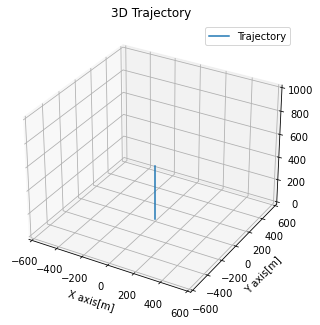

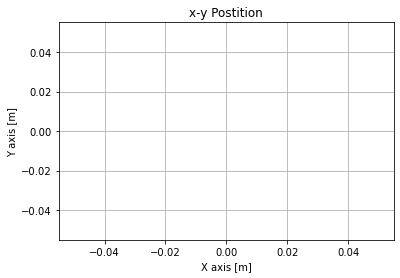

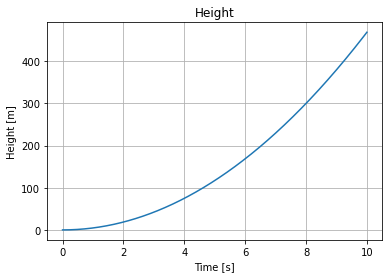

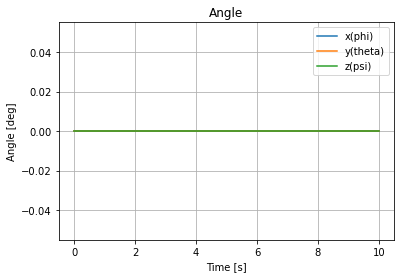

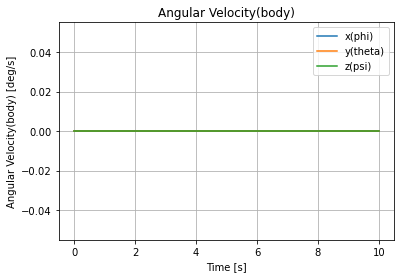

In [11]:
if __name__ == "__main__":
    quad_model = derive_equations()
    data = simulate(quad_model, 0.01, 10)

    fig1 = plt.figure(1)
    ax = Axes3D(fig1)
    ax.set_xlim3d(-600,600)
    ax.set_ylim3d(-600,600)
    ax.set_zlim3d(0,1000)
    plt.plot(data['x'][:,9],
             data['x'][:,10],
             data['x'][:,11])
    plt.title('3D Trajectory')
    plt.xlabel('X axis[m]')
    plt.ylabel('Y axis[m]')
    plt.legend(['Trajectory'])
    plt.grid()

    fig2 = plt.figure(2)
    plt.plot(data['x'][:,9],
              data['x'][:,10],)
    plt.title('x-y Postition')
    plt.xlabel('X axis [m]')
    plt.ylabel('Y axis [m]')
    plt.grid()
    
    fig3 = plt.figure(3)
    plt.plot(data['t'],data['x'][:,11])
    plt.title('Height')
    plt.xlabel('Time [s]')
    plt.ylabel('Height [m]')
    plt.grid()
    
    fig3 = plt.figure(4)
    plt.plot(data['t'], data['x'][:,6]*180/ca.pi,
             data['t'], data['x'][:,7]*180/ca.pi,
             data['t'], data['x'][:,8]*180/ca.pi)
    plt.title('Angle')
    plt.xlabel('Time [s]')
    plt.ylabel('Angle [deg]')
    plt.legend(['x(phi)','y(theta)','z(psi)'])
    plt.grid()
    
    plt.figure(5)
    plt.plot(data['t'], data['x'][:,0]*180/ca.pi,
             data['t'], data['x'][:,1]*180/ca.pi,
             data['t'], data['x'][:,2]*180/ca.pi)
    plt.title('Angular Velocity(body)')
    plt.xlabel('Time [s]')
    plt.ylabel('Angular Velocity(body) [deg/s]')
    plt.legend(['x(phi)','y(theta)','z(psi)'])
    plt.grid()